In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.metrics import log_loss,roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from prettytable import PrettyTable
from tqdm import tqdm

In [150]:
data = pd.read_csv("in-vehicle-coupon-recommendation.csv")
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [152]:
print("Number of data points:", data.shape[0])
print("Number of features:", data.shape[1])
print('-'*100)
print("The attributes of data :", data.columns.values)

Number of data points: 12684
Number of features: 26
----------------------------------------------------------------------------------------------------
The attributes of data : ['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'car' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ5min'
 'toCoupon_GEQ15min' 'toCoupon_GEQ25min' 'direction_same' 'direction_opp'
 'Y']


In [153]:
Y_counts = data.groupby('Y').Y.count()
print('Phiếu giảm giá được chấp nhận:',Y_counts[1],round(Y_counts[1]/data.shape[0]*100,3),'%')
print('Phiếu giảm giá bị từ chối:',Y_counts[0],round(Y_counts[0]/data.shape[0]*100,3),'%')

Phiếu giảm giá được chấp nhận: 7210 56.843 %
Phiếu giảm giá bị từ chối: 5474 43.157 %


In [154]:
# Xóa lặp
duplicate = data[data.duplicated(keep = 'last')]
data = data.drop_duplicates()
print("Tệp dữ liệu sau khi xóa bỏ lặp",data.shape)

Tệp dữ liệu sau khi xóa bỏ lặp (12610, 26)


In [155]:
#Giá trị bị thiếu
print('Có bất kỳ giá trị nào bị thiếu hay không?',data.isnull().values.any())
missing_percentage = data.isnull().sum()*100/len(data)
missing_value_df = pd.DataFrame({'missing_count': data.isnull().sum(),'missing_percentage': missing_percentage})
missing_value_df[missing_value_df.missing_count != 0]

Có bất kỳ giá trị nào bị thiếu hay không? True


,missing_count,missing_percentage
car,12502,99.143537
Bar,107,0.848533
CoffeeHouse,217,1.720856
CarryAway,150,1.189532
RestaurantLessThan20,129,1.022998
Restaurant20To50,189,1.498810


In [156]:
data = data.drop(['car'], axis=1)

In [157]:
# điền các dữ liệu bị thiếu bằng cách sử dụng mode imputation
data['Bar']=data['Bar'].fillna(data['Bar'].value_counts().index[0])
data['CoffeeHouse']=data['CoffeeHouse'].fillna(data['CoffeeHouse'].value_counts().index[0])
data['CarryAway']=data['CarryAway'].fillna(data['CarryAway'].value_counts().index[0])
data['RestaurantLessThan20']=data['RestaurantLessThan20'].fillna(data['RestaurantLessThan20'].value_counts().index[0])
data['Restaurant20To50']=data['Restaurant20To50'].fillna(data['Restaurant20To50'].value_counts().index[0])

In [158]:
#Giá trị bị thiếu
print('Có bất kỳ giá trị nào bị thiếu hay không?',data.isnull().values.any())

Có bất kỳ giá trị nào bị thiếu hay không? False


In [159]:
data.corr()

C:\Users\vihoa\AppData\Local\Temp\ipykernel_6684\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
temperature,1.000000,-0.018599,NaN,-0.157089,-0.227165,0.097972,-0.097972,0.059393
has_children,-0.018599,1.000000,NaN,0.079434,-0.010773,-0.032353,0.032353,-0.045056
toCoupon_GEQ5min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toCoupon_GEQ15min,-0.157089,0.079434,NaN,1.000000,0.321260,-0.302066,0.302066,-0.082693
toCoupon_GEQ25min,-0.227165,-0.010773,NaN,0.321260,1.000000,-0.189900,0.189900,-0.108139
direction_same,0.097972,-0.032353,NaN,-0.302066,-0.189900,1.000000,-1.000000,0.014932
direction_opp,-0.097972,0.032353,NaN,0.302066,0.189900,-1.000000,1.000000,-0.014932
Y,0.059393,-0.045056,NaN,-0.082693,-0.108139,0.014932,-0.014932,1.000000


In [160]:
data = data.drop(['direction_opp','toCoupon_GEQ5min'], axis=1)
data.shape

(12610, 23)

In [161]:
data.corr()

C:\Users\vihoa\AppData\Local\Temp\ipykernel_6684\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
temperature,1.000000,-0.018599,-0.157089,-0.227165,0.097972,0.059393
has_children,-0.018599,1.000000,0.079434,-0.010773,-0.032353,-0.045056
toCoupon_GEQ15min,-0.157089,0.079434,1.000000,0.321260,-0.302066,-0.082693
toCoupon_GEQ25min,-0.227165,-0.010773,0.321260,1.000000,-0.189900,-0.108139
direction_same,0.097972,-0.032353,-0.302066,-0.189900,1.000000,0.014932
Y,0.059393,-0.045056,-0.082693,-0.108139,0.014932,1.000000


In [162]:
def univariate_analysis(column_name):
    df_EDA = pd.DataFrame(sorted(list(data[column_name].unique())),columns=[column_name])
    df_EDA['Tổng số lượng'] = list(data.groupby(column_name).Y.count())
    df_EDA['Chấp nhận'] = list(data[data.Y==1].groupby(column_name).Y.count())
    df_EDA['Từ chối'] = list(data[data.Y==0].groupby(column_name).Y.count())
    df_EDA['Phần trăm chấp nhận'] = round(df_EDA['Chấp nhận']/df_EDA['Tổng số lượng']*100,3)
    df_EDA['Phần trăm từ chối'] = round(df_EDA['Từ chối']/df_EDA['Tổng số lượng']*100,3)
    df_EDA = df_EDA.sort_values(by='Tổng số lượng', ascending=False)
    
    fig = plt.subplots(figsize =(8, 4))
    plt.barh(df_EDA[column_name],df_EDA['Tổng số lượng'])
    plt.barh(df_EDA[column_name],df_EDA['Chấp nhận'])
    plt.legend(labels=['Từ chối','Chấp nhận'])
    plt.xlabel('Số lượng')
    plt.title(column_name)
    plt.show()

    return df_EDA

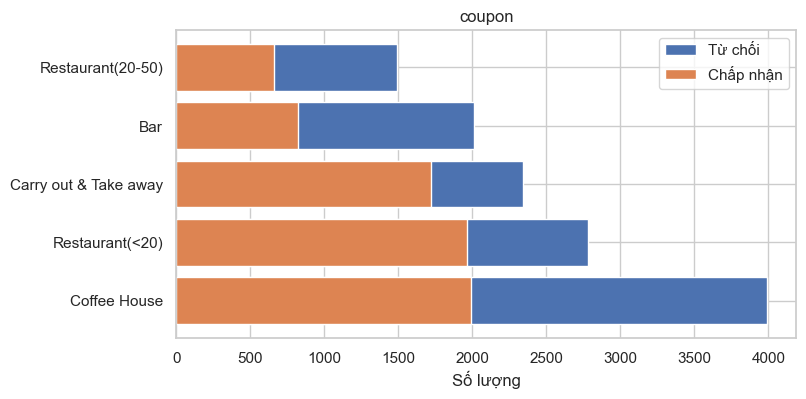

,coupon,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
2,Coffee House,3989,1989,2000,49.862,50.138
4,Restaurant(<20),2779,1967,812,70.781,29.219
1,Carry out & Take away,2344,1720,624,73.379,26.621
0,Bar,2010,824,1186,40.995,59.005
3,Restaurant(20-50),1488,657,831,44.153,55.847


In [163]:
univariate_analysis('coupon')

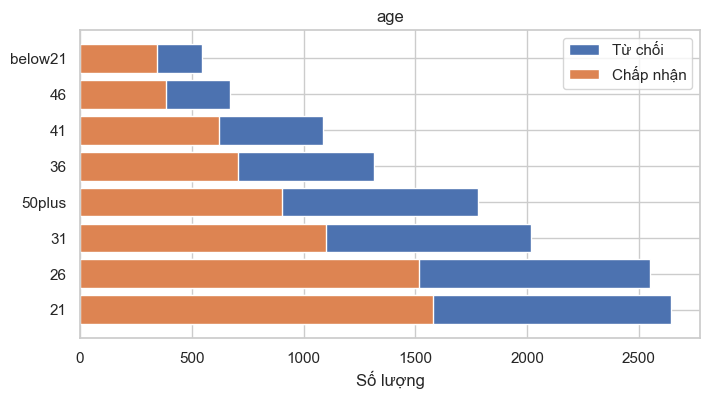

,age,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
0,21,2642,1579,1063,59.765,40.235
1,26,2548,1517,1031,59.537,40.463
2,31,2019,1102,917,54.581,45.419
6,50plus,1781,903,878,50.702,49.298
3,36,1317,705,612,53.531,46.469
4,41,1089,623,466,57.208,42.792
5,46,670,384,286,57.313,42.687
7,below21,544,344,200,63.235,36.765


In [164]:
univariate_analysis('age')

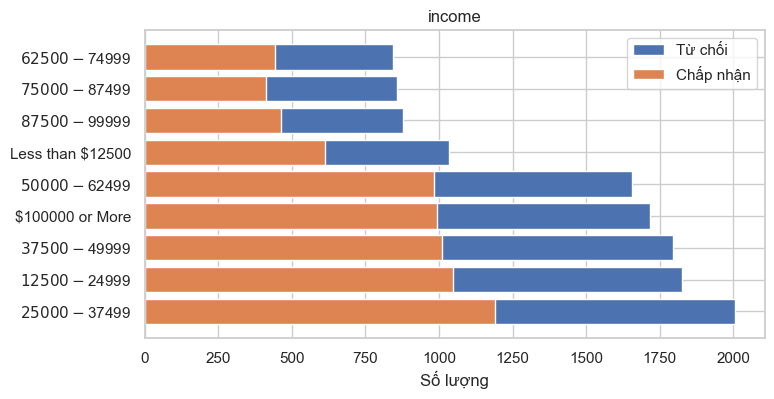

,income,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
2,$25000 - $37499,2006,1190,816,59.322,40.678
1,$12500 - $24999,1825,1047,778,57.370,42.630
3,$37500 - $49999,1795,1010,785,56.267,43.733
0,$100000 or More,1717,992,725,57.775,42.225
4,$50000 - $62499,1655,984,671,59.456,40.544
8,Less than $12500,1034,612,422,59.188,40.812
7,$87500 - $99999,879,465,414,52.901,47.099
6,$75000 - $87499,856,414,442,48.364,51.636
5,$62500 - $74999,843,443,400,52.550,47.450


In [165]:
univariate_analysis('income')

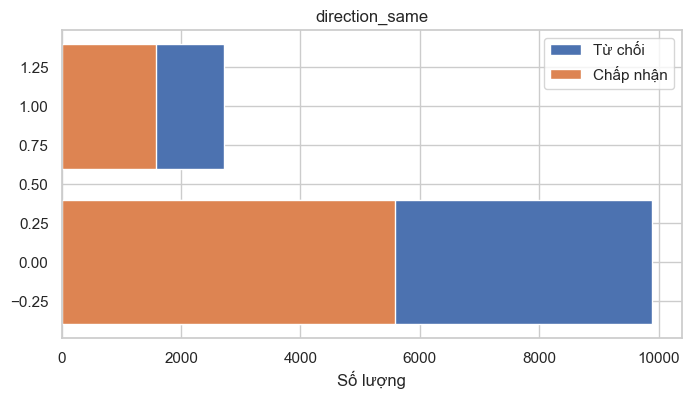

,direction_same,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
0,0,9892,5576,4316,56.369,43.631
1,1,2718,1581,1137,58.168,41.832


In [166]:
univariate_analysis('direction_same')

In [167]:
data = data.drop(['direction_same'], axis=1)
data.shape
data.corr()

C:\Users\vihoa\AppData\Local\Temp\ipykernel_6684\3568473958.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,Y
temperature,1.000000,-0.018599,-0.157089,-0.227165,0.059393
has_children,-0.018599,1.000000,0.079434,-0.010773,-0.045056
toCoupon_GEQ15min,-0.157089,0.079434,1.000000,0.321260,-0.082693
toCoupon_GEQ25min,-0.227165,-0.010773,0.321260,1.000000,-0.108139
Y,0.059393,-0.045056,-0.082693,-0.108139,1.000000


In [168]:
def bivariate_analysis(col1,col2,c1,c2,no_row):
    a = list(data[col1].unique())
    b = list(data[col2].unique())
    df = pd.DataFrame([(i, j) for i in a for j in b], columns=[col1,col2])
    Total_Count=[]; Accepted=[]; Rejected=[]
    for i in range(df.shape[0]):
        Total_Count.append((data[(c1==df[col1][i]) & (c2==df[col2][i])]).shape[0])
        Accepted.append((data[(c1==df[col1][i]) & (c2==df[col2][i]) & (data.Y==1)]).shape[0])
        Rejected.append((data[(c1==df[col1][i]) & (c2==df[col2][i]) & (data.Y==0)]).shape[0])
    df['Tổng số lượng'] = Total_Count
    df['Chấp nhận'] = Accepted
    df['Từ chối'] = Rejected
    df['Phần trăm chấp nhận'] = round(df['Chấp nhận']/df['Tổng số lượng']*100,3)
    df['Phần trăm từ chối'] = round(df['Từ chối']/df['Tổng số lượng']*100,3)
    df = df.dropna()
    df = df.sort_values(by='Phần trăm chấp nhận', ascending=False)
    d = pd.concat([df.head(no_row), df.tail(no_row)], axis=0)
    return d

Text(0.5, 1.0, 'Điểm đến so với thời gian(Số lượng)')

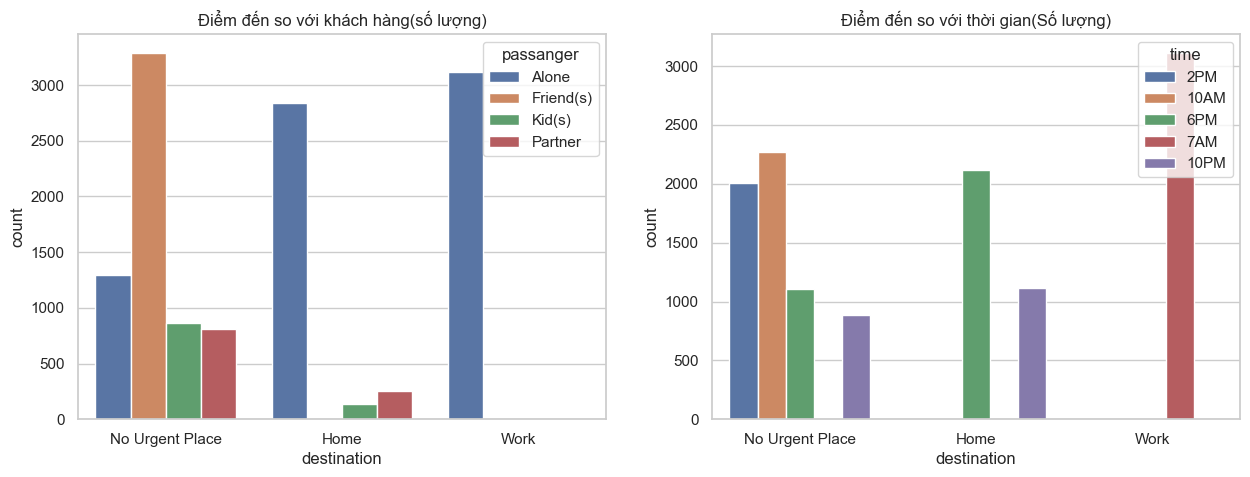

In [169]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x = data['destination'],hue=data['passanger'],ax=axes[0])
sns.countplot(x = data['destination'],hue=data['time'],ax=axes[1])
axes[0].set_title('Điểm đến so với khách hàng(số lượng)'); axes[1].set_title('Điểm đến so với thời gian(Số lượng)')

In [170]:
bivariate_analysis('destination','time',data.destination,data.time,3)

,destination,time,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
2,No Urgent Place,6PM,1102,730,372,66.243,33.757
0,No Urgent Place,2PM,2006,1327,679,66.152,33.848
1,No Urgent Place,10AM,2271,1380,891,60.766,39.234
7,Home,6PM,2118,1151,967,54.344,45.656
13,Work,7AM,3114,1553,1561,49.872,50.128
9,Home,10PM,1112,484,628,43.525,56.475


In [171]:
bivariate_analysis('passanger','time',data.passanger,data.time,3)

,passanger,time,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
7,Friend(s),6PM,592,448,144,75.676,24.324
0,Alone,2PM,361,265,96,73.407,26.593
17,Partner,6PM,309,216,93,69.903,30.097
12,Kid(s),6PM,267,125,142,46.816,53.184
4,Alone,10PM,990,461,529,46.566,53.434
14,Kid(s),10PM,167,43,124,25.749,74.251


Text(0.5, 1.0, 'Thời gian so với phiếu giảm giá, thời hạn: 2h (số lượng)')

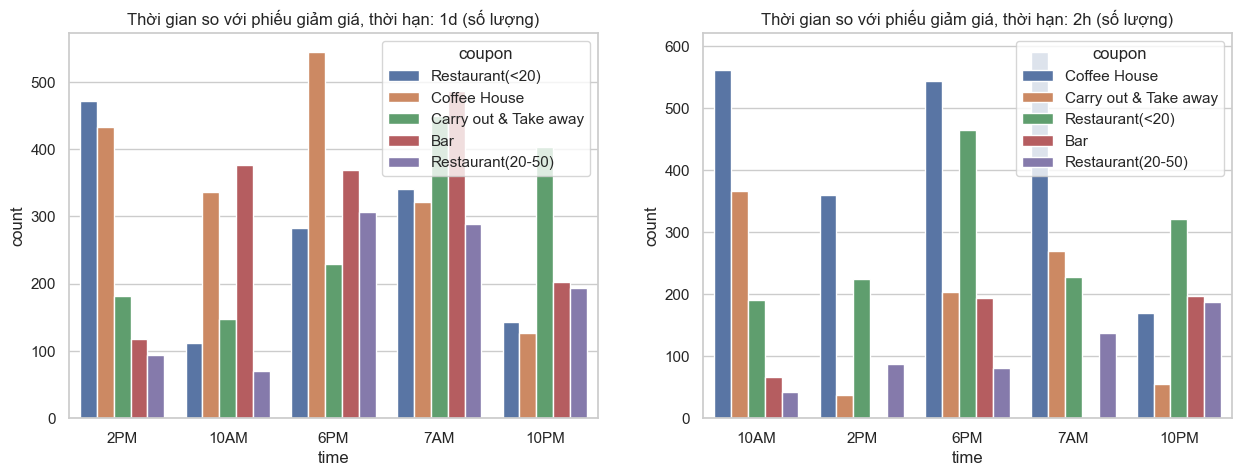

In [172]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x = data[data.expiration == '1d']['time'],hue=data[data.expiration == '1d']['coupon'],ax=axes[0])
sns.countplot(x = data[data.expiration == '2h']['time'],hue=data[data.expiration == '2h']['coupon'],ax=axes[1])
axes[0].set_title('Thời gian so với phiếu giảm giá, thời hạn: 1d (số lượng)'); axes[1].set_title('Thời gian so với phiếu giảm giá, thời hạn: 2h (số lượng)')

In [173]:
bivariate_analysis('coupon','time',data.coupon,data.time,4)

,coupon,time,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
10,Carry out & Take away,2PM,218,189,29,86.697,13.303
2,Restaurant(<20),6PM,748,619,129,82.754,17.246
12,Carry out & Take away,6PM,433,357,76,82.448,17.552
0,Restaurant(<20),2PM,696,567,129,81.466,18.534
18,Bar,7AM,487,178,309,36.550,63.450
16,Bar,10AM,443,160,283,36.117,63.883
15,Bar,2PM,118,40,78,33.898,66.102
24,Restaurant(20-50),10PM,380,125,255,32.895,67.105


In [174]:
# FE -- to_Coupon is combination of two feature, toCoupon_GEQ15min and toCoupon_GEQ25min
to_Coupon = []
for i in tqdm(range(data.shape[0])):
    if (list(data['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(data['toCoupon_GEQ15min'])[i] == 1)and(list(data['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)
        
# print(len(to_Coupon)) #12610
data['to_Coupon'] = to_Coupon
print('Unique values:',data['to_Coupon'].unique())
print('-'*50)
data['to_Coupon'].describe()

100%|██████████| 12610/12610 [00:18<00:00, 676.68it/s]

Unique values: [0 1 2]
--------------------------------------------------


count    12610.000000
mean         0.675813
std          0.671687
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: to_Coupon, dtype: float64

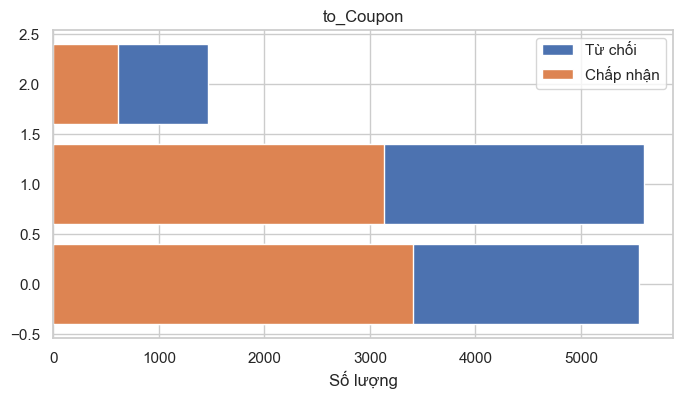

,to_Coupon,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
1,1,5596,3136,2460,56.040,43.960
0,0,5551,3407,2144,61.376,38.624
2,2,1463,614,849,41.969,58.031


In [175]:
univariate_analysis('to_Coupon')

In [176]:
# FE -- coupon_freq is combination of five features, RestaurantLessThan20, CoffeeHouse, CarryAway, Bar, Restaurant20To50
coupon_freq = []
for i in tqdm(range(data.shape[0])):
    if (list(data['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(data['RestaurantLessThan20'])[i])
    elif (list(data['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(data['CoffeeHouse'])[i])
    elif (list(data['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(data['CarryAway'])[i])
    elif (list(data['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(data['Bar'])[i])
    elif (list(data['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(data['Restaurant20To50'])[i])
        
data['coupon_freq'] = coupon_freq
print('Unique values:',data['coupon_freq'].unique())
print('-'*50)
data['coupon_freq'].describe()

100%|██████████| 12610/12610 [00:31<00:00, 400.06it/s]

Unique values: ['4~8' 'never' '1~3' 'less1' 'gt8']
--------------------------------------------------


count     12610
unique        5
top         1~3
freq       3870
Name: coupon_freq, dtype: object

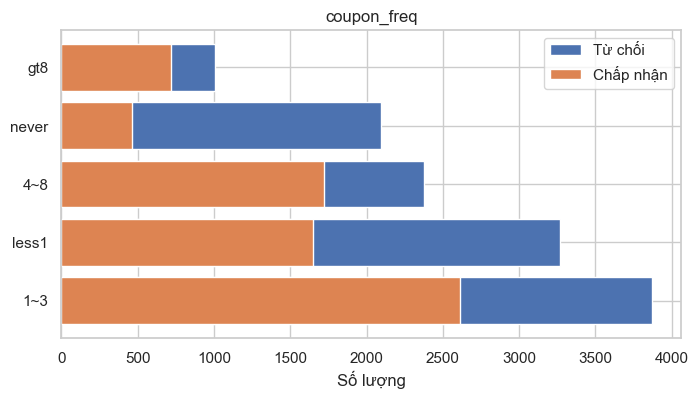

,coupon_freq,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
0,1~3,3870,2609,1261,67.416,32.584
3,less1,3265,1650,1615,50.536,49.464
1,4~8,2378,1721,657,72.372,27.628
4,never,2093,460,1633,21.978,78.022
2,gt8,1004,717,287,71.414,28.586


In [177]:
univariate_analysis('coupon_freq')

In [178]:
data['occupation'].describe()

count          12610
unique            25
top       Unemployed
freq            1861
Name: occupation, dtype: object

In [179]:
# occupation feature has 25 no of distinct values, which creates very sparsity in data after Encoding
# FE -- occupation_class where categorize all occupation in its suitable class.
occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
# occupation_dict
data['occupation_class'] = data['occupation'].map(occupation_dict)
print('Unique values:',data['occupation_class'].unique())
print('-'*50)
data['occupation_class'].describe()

Unique values: ['Medium_Low_Acceptance' 'High_Acceptance' 'Medium_High_Acceptance'
 'Low_Acceptance' 'Medium_Acceptance']
--------------------------------------------------


count                     12610
unique                        5
top       Medium_Low_Acceptance
freq                       3300
Name: occupation_class, dtype: object

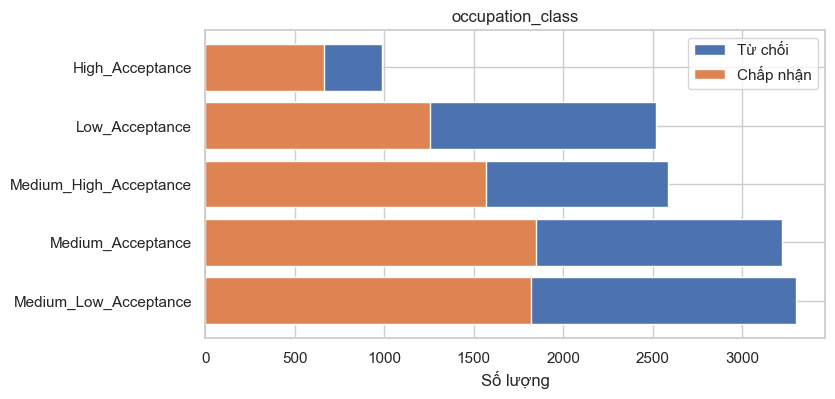

,occupation_class,Tổng số lượng,Chấp nhận,Từ chối,Phần trăm chấp nhận,Phần trăm từ chối
4,Medium_Low_Acceptance,3300,1821,1479,55.182,44.818
2,Medium_Acceptance,3221,1849,1372,57.405,42.595
3,Medium_High_Acceptance,2583,1566,1017,60.627,39.373
1,Low_Acceptance,2517,1258,1259,49.980,50.020
0,High_Acceptance,989,663,326,67.037,32.963


In [180]:
univariate_analysis('occupation_class')

In [181]:
# After Feature Engineering, removing unwanted features
data = data.drop(['toCoupon_GEQ15min','toCoupon_GEQ25min','Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50','occupation'], axis=1)
print('-'*50)
print(data.columns.values)

--------------------------------------------------
['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'income' 'Y' 'to_Coupon' 'coupon_freq' 'occupation_class']


In [182]:
X = data.drop(['Y'], axis=1)
y = data['Y'].values
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10088, 16) (10088,)
(2522, 16) (2522,)


In [183]:
def frequency_enc(column_name,X):
  """It returns Frequency encoded feature"""
  return X[column_name].map(X.groupby(column_name).size()/len(X))

In [184]:
X_train_frequency_encoding = pd.DataFrame()
for i in range(X_train.shape[1]):
  X_train_frequency_encoding[X_train.columns.values[i]+'_freq_enc'] = frequency_enc(X_train.columns.values[i],X_train)

print('X_train_frequency_encoding:',X_train_frequency_encoding.shape)
X_train_frequency_encoding.head(3)

X_train_frequency_encoding: (10088, 16)


,destination_freq_enc,passanger_freq_enc,weather_freq_enc,temperature_freq_enc,time_freq_enc,coupon_freq_enc,expiration_freq_enc,gender_freq_enc,age_freq_enc,maritalStatus_freq_enc,has_children_freq_enc,education_freq_enc,income_freq_enc,to_Coupon_freq_enc,coupon_freq_freq_enc,occupation_class_freq_enc
74,0.498017,0.082078,0.794806,0.516059,0.180412,0.184377,0.443894,0.487708,0.052240,0.404342,0.418319,0.341297,0.069588,0.448949,0.304322,0.198850
11947,0.254857,0.082672,0.794806,0.181503,0.253271,0.218874,0.556106,0.512292,0.159893,0.404342,0.581681,0.341197,0.135706,0.116079,0.188045,0.256542
12296,0.254857,0.571768,0.111023,0.181503,0.158505,0.184377,0.556106,0.512292,0.141951,0.009715,0.418319,0.071372,0.141455,0.116079,0.188045,0.198850


In [185]:
X_test_frequency_encoding = pd.DataFrame()
for i in range(X_test.shape[1]):
  X_test_frequency_encoding[X_test.columns.values[i]+'_freq_enc'] = frequency_enc(X_test.columns.values[i],X_test)

print('X_test_frequency_encoding:',X_test_frequency_encoding.shape)
X_test_frequency_encoding.head(3)

X_test_frequency_encoding: (2522, 16)


,destination_freq_enc,passanger_freq_enc,weather_freq_enc,temperature_freq_enc,time_freq_enc,coupon_freq_enc,expiration_freq_enc,gender_freq_enc,age_freq_enc,maritalStatus_freq_enc,has_children_freq_enc,education_freq_enc,income_freq_enc,to_Coupon_freq_enc,coupon_freq_freq_enc,occupation_class_freq_enc
6730,0.246233,0.586836,0.790246,0.503172,0.246233,0.305710,0.563442,0.51586,0.160983,0.392149,0.399286,0.092784,0.144726,0.423077,0.317209,0.262490
3903,0.261301,0.586836,0.790246,0.503172,0.263680,0.305710,0.436558,0.48414,0.138382,0.378271,0.600714,0.348929,0.061063,0.461142,0.165345,0.250991
1910,0.261301,0.586836,0.790246,0.308882,0.263680,0.168517,0.563442,0.48414,0.160983,0.378271,0.600714,0.348929,0.081681,0.461142,0.248216,0.262490


In [186]:
y_pred_test = []
for i in range(len(y_test)):
    r = np.random.random()
    if r<0.5:
        y_pred_test.append(0)
    else:
        y_pred_test.append(1)

print("log_loss on Test Data using Random Model is",log_loss(y_test,y_pred_test))
print("roc_auc_score on Test Data using Random Model is",roc_auc_score(y_test,y_pred_test))

log_loss on Test Data using Random Model is 18.593494472339973
roc_auc_score on Test Data using Random Model is 0.48553375851336866


In [187]:
def Logistic_Regression(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Logistic Regression Model"""

  clf = LogisticRegression(random_state=0,C=1.0)
  parameters = {'C':[0.01, 0.1, 1, 10, 100, 500]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_C = model.best_params_['C']

  clf = LogisticRegression(random_state=0,C=best_C).fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_C,Train_loss,Train_AUC,Test_loss,Test_AUC

In [ ]:
# Frequency Encoding
best_C_FreEnc, Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = Logistic_Regression(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)

In [189]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Logistic Regression","Frequency Encoding",best_C_FreEnc,'',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])

table = pd.read_html(summary_table.get_html_string())
Logistic_Regression_Result = table[0]
Logistic_Regression_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Logistic Regression,Frequency Encoding,100,NaN,0.651,0.641,0.655,0.638


In [190]:
def K_Neighbors_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of K-Nearest Neighbors Model"""

  clf = KNeighborsClassifier()
  parameters = {'n_neighbors':[11, 15, 21, 31, 41, 51]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_n_neighbors = model.best_params_['n_neighbors']

  clf = KNeighborsClassifier(n_neighbors=best_n_neighbors).fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_n_neighbors,Train_loss,Train_AUC,Test_loss,Test_AUC

In [ ]:
# Frequency Encoding
best_n_FreEnc, Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = K_Neighbors_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)

In [192]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["K-Nearest Neighbor","Frequency Encoding",best_n_FreEnc,'',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])

table = pd.read_html(summary_table.get_html_string())
K_Nearest_Neighbor_Result = table[0]
K_Nearest_Neighbor_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,K-Nearest Neighbor,Frequency Encoding,21,NaN,0.587,0.742,0.653,0.67


In [193]:
def Decision_Tree_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Decision Trees Model"""

  clf = DecisionTreeClassifier(class_weight='balanced')
  parameters = {'max_depth':[1, 5, 10, 50], 'min_samples_split':[5, 10, 100, 500]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_depth = model.best_params_['max_depth']
  best_samples_split = model.best_params_['min_samples_split']

  clf = DecisionTreeClassifier(class_weight='balanced', max_depth=best_depth, min_samples_split=best_samples_split, random_state=0)
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_depth,best_samples_split,Train_loss,Train_AUC,Test_loss,Test_AUC

In [194]:
# Frequency Encoding
best_depth_FreEnc,best_samples_split_FreEnc,Train_loss_FreEnc,Train_AUC_FreEnc,Test_loss_FreEnc,Test_AUC_FreEnc = Decision_Tree_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)

In [195]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Decision Tree","Frequency Encoding",best_depth_FreEnc,best_samples_split_FreEnc,round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])

table = pd.read_html(summary_table.get_html_string())
Decision_Tree_Result = table[0]
Decision_Tree_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Decision Tree,Frequency Encoding,10,100,0.527,0.81,0.836,0.727


In [196]:
Model_Result = [Logistic_Regression_Result,K_Nearest_Neighbor_Result,Decision_Tree_Result] 
Result = pd.concat(Model_Result,ignore_index=True)
(Result).sort_values(by=['Test_roc_auc_score'],ascending=False).head(10)

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
2,Decision Tree,Frequency Encoding,10,100.0,0.527,0.810,0.836,0.727
1,K-Nearest Neighbor,Frequency Encoding,21,NaN,0.587,0.742,0.653,0.670
0,Logistic Regression,Frequency Encoding,100,NaN,0.651,0.641,0.655,0.638


C:\Users\vihoa\AppData\Local\Temp\ipykernel_6684\2225894155.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(Result.pivot('Model','Encoding','Test_roc_auc_score'), annot = True, fmt='.3g', ax=ax[0])
C:\Users\vihoa\AppData\Local\Temp\ipykernel_6684\2225894155.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(Result.pivot('Model','Encoding','Test_log_loss'), annot = True, fmt='.3g', cmap=sns.cm.rocket_r, ax=ax[1])


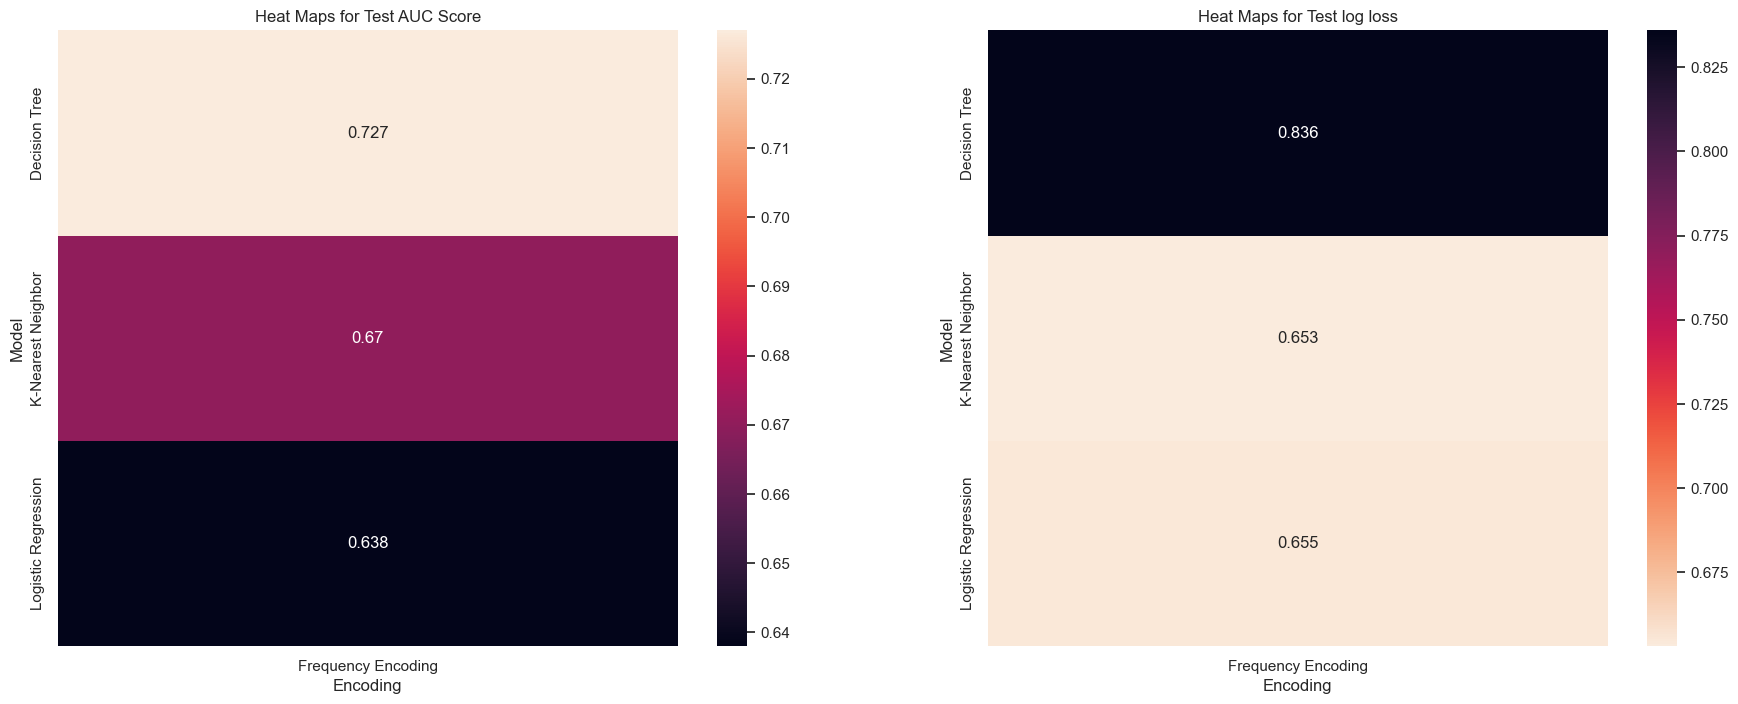

In [197]:
fig, ax = plt.subplots(1,2, figsize=(22,8))
sns.heatmap(Result.pivot('Model','Encoding','Test_roc_auc_score'), annot = True, fmt='.3g', ax=ax[0])
sns.heatmap(Result.pivot('Model','Encoding','Test_log_loss'), annot = True, fmt='.3g', cmap=sns.cm.rocket_r, ax=ax[1])
ax[0].set_title('Heat Maps for Test AUC Score')
ax[1].set_title('Heat Maps for Test log loss')
plt.show()